<a href="https://colab.research.google.com/github/Humboldt-Penguin/Lightkurve-Exoplanets/blob/main/Lightkurve_Exoplanets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Background

The **transit method** involves analyzing the luminosity of a star over time in search of periodic decreases in luminosity associated with an exoplanet passing in front of the star, or a "transit" (opposite of an eclipse). 

\

The transit method alone can give us information about an exoplanet's radius and period of revolution. When combined with other techniques such as the radial velocity method, we can also determine the mass and therefore density.

\

The transit method was first used to confirm the existence of an exoplanet in 1999 (Charbonneau et al 2000). Fun fact, they did this with a 10 cm diameter telescope installed in a parking lot! Later in 2003, the transit method discovered its first original exoplanet.

## Installing Lightkurve (hide this cell)

In [3]:
!pip install lightkurve

     |████████████████████████████████| 247 kB 5.2 MB/s 
     |████████████████████████████████| 4.5 MB 61.4 MB/s 
     |████████████████████████████████| 41 kB 167 kB/s 
     |████████████████████████████████| 98 kB 7.4 MB/s 
     |████████████████████████████████| 832 kB 55.2 MB/s 
     |████████████████████████████████| 54 kB 2.1 MB/s 
     |████████████████████████████████| 3.6 MB 42.6 MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11375 sha256=debe4fd71dcf817dcd3a8f5c4bd3450322dc08b91655259c01a7341f83e40c7c
  Stored in directory: /root/.cache/pip/wheels/93/08/0c/1b9866c35c8d3f136d100dfe88036a32e0795437daca089f70
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=341dc45dca28effbf3d7171d5b1c8175c00da28bc331f8d16997b37f5278fc56
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for oktopus: filename=oktopus-0.1.2-py3-none-any.whl size=12779 s

---
# 1. Basics of Pixel Files/Light Curves with Tabby's Star

## Pixel Files

The [TESS telescope](https://archive.stsci.edu/missions-and-data/tess) has four 4-megapixel charge-coupled device (CCD) cameras [or "photometers" if you want to be fancy] that collect light in the 600 to 1000 nm range. These data are often called **"pixel files"**.

\

For a star's designated location, Lightkurve will give us a target pixel file containing a 2D array of luminosity values over some period of time. Let's take a look at one of my favorite discoveries from the Kepler telescope, Tabby's Star!

First we download the target pixel file:

In [4]:
from lightkurve import search_targetpixelfile

# Download pixelfile at a certain location and time (in this case, year 4 of Kepler's life)
tabby_pf = search_targetpixelfile("KIC 8462852", quarter=16).download(quality_bitmask='hardest');

Now can look at any individual frame of the pixel file:

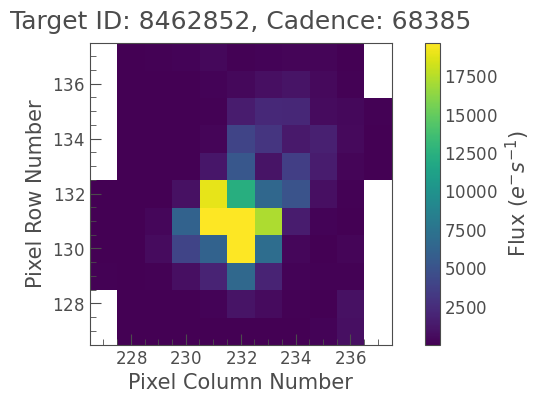

In [5]:
tabby_pf.plot(frame=1000);

However, these are really only for visualization purposes. 


## Light Curves

For meaningful analysis, we convert our pixel files into "lightcurve" objects with Simple Aperture Photometry. This might sound fancy, but it simply means summing up the values of all the pixels in a pre-defined aperture as a function of time. We filter out noise/contaminants to amplify the signal we're interested in by carefully selecting an aperture mask.

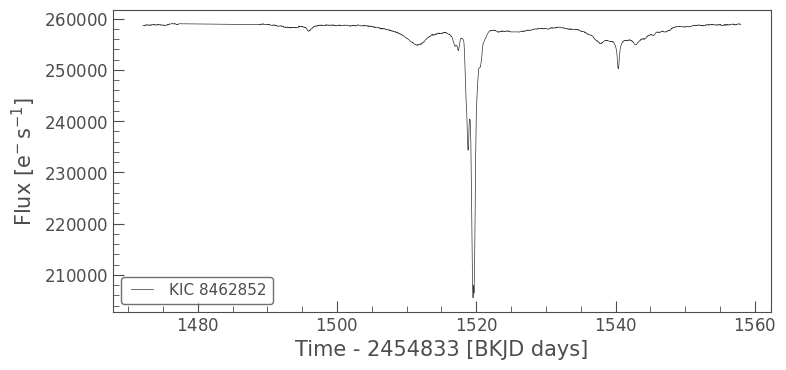

In [6]:
tabby_lc = tabby_pf.to_lightcurve(aperture_mask='all');
tabby_lc.plot();

Very curious! There are a lot of theories as to what causes this dip in luminosity, but we can't conclude the existence of exoplanets from this since the dips aren't periodic. 

---
# 2. Potential Exoplanet Case Study

If we look at another star's light curve:

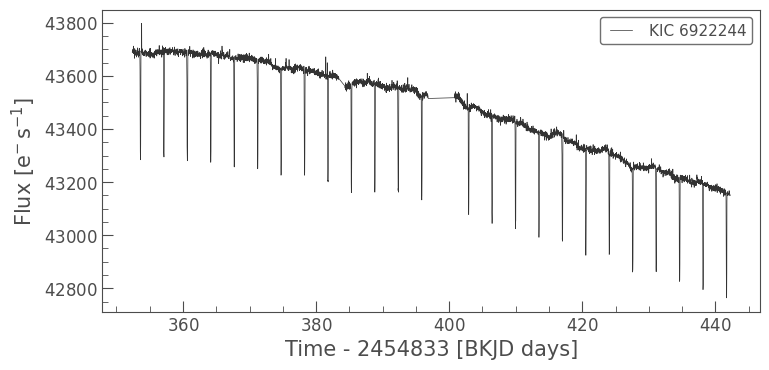

In [22]:
mystery_pf = search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=4).download()
mystery_lc = mystery_pf.to_lightcurve(aperture_mask=mystery_pf.pipeline_mask)
mystery_lc.plot();

Here we observe fairly periodic dips that could be due to an exoplanet's transit. The overall dimming over time could be due to a variable star, and the distrubance around time=400 turned out to be just be noise after the Kepler telescope experienced some perturbations.
We "flatten" the graph to ignore the overall dimming:

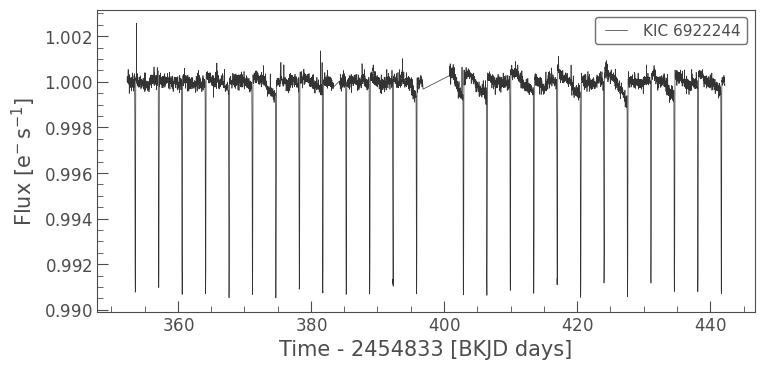

In [23]:
mystery_lc_flat = mystery_lc.flatten(window_length=401)
mystery_lc_flat.plot();

And from here, it doesn't seem too unreasonable to start guessing the planet's orbit period and even size! 

We can extract the average interval between each dip like so:

Best fit period: 1.76132 d


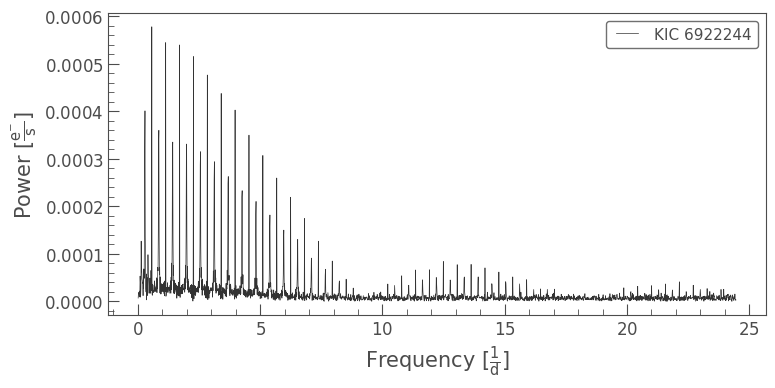

In [31]:
import numpy as np

mystery_pg = mystery_lc_flat.to_periodogram(oversample_factor=1)
mystery_pg.plot();

period = mystery_pg.period_at_max_power
print('Best fit period: {:.5f}'.format(period))

And then use multiples of that period to "fold" all of the dips in our original flattened light curve together until we observe a clean dip:

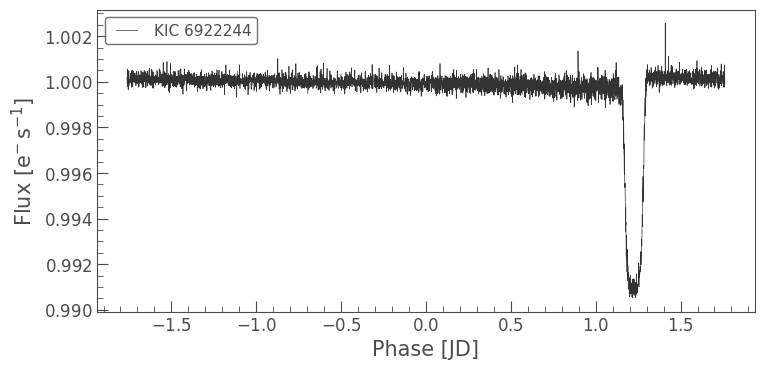

In [28]:
mystery_lc_folded = mystery_lc_flat.fold(period=period*2)
mystery_lc_folded.plot();

And we can further clean this up as such:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: LightkurveDeprecationWarning: "binsize" was deprecated in version 2.0 and will be removed in a future version. 
        Use time_bin_size instead.
  """Entry point for launching an IPython kernel.


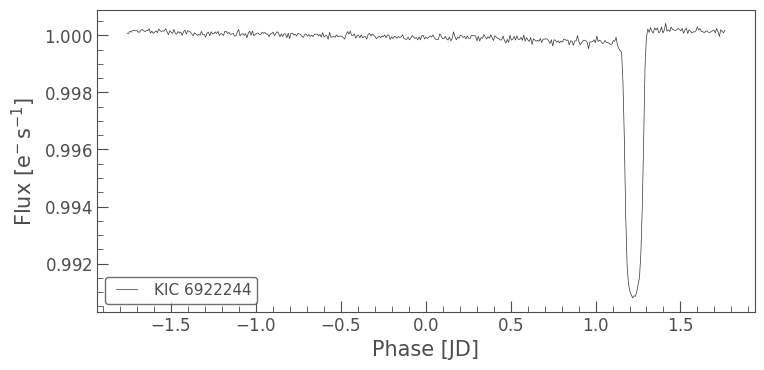

In [34]:
mystery_lc_binned = mystery_lc_folded.bin(binsize=10)
mystery_lc_binned.plot();

Based on this, we have strong evidence to suggest an exoplanet with an orbital period of 3.52 days!

---
# 2. Downloading Kepler/TESS Data with Astroquery (Needs Documentation)

In [40]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

In [41]:
search = lk.search_lightcurve('KIC 3733346', author='Kepler')
print(search)

SearchResult containing 18 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 01 2009 Kepler    1800 kplr003733346      0.0
  1 Kepler Quarter 02 2009 Kepler    1800 kplr003733346      0.0
  2 Kepler Quarter 03 2009 Kepler    1800 kplr003733346      0.0
  3 Kepler Quarter 04 2010 Kepler    1800 kplr003733346      0.0
  4 Kepler Quarter 05 2010 Kepler    1800 kplr003733346      0.0
  5 Kepler Quarter 06 2010 Kepler    1800 kplr003733346      0.0
  6 Kepler Quarter 07 2010 Kepler    1800 kplr003733346      0.0
  7 Kepler Quarter 08 2011 Kepler    1800 kplr003733346      0.0
  8 Kepler Quarter 09 2011 Kepler    1800 kplr003733346      0.0
  9 Kepler Quarter 10 2011 Kepler    1800 kplr003733346      0.0
 10 Kepler Quarter 11 2011 Kepler      60 kplr003733346      0.0
 11 Kepler Quarter 11 2012 Kepler    1800 kplr0

In [39]:
for column in search.table.columns:
    print(column)

dataproduct_type
calib_level
obs_collection
obs_id
target_name
s_ra
s_dec
t_min
t_max
t_exptime
wavelength_region
filters
em_min
em_max
target_classification
obs_title
t_obs_release
instrument_name
proposal_pi
proposal_id
proposal_type
project
sequence_number
provenance_name
s_region
jpegURL
dataURL
dataRights
mtFlag
srcDen
intentType
obsid
objID
exptime
distance
obsID
obs_collection_products
dataproduct_type_products
description
type
dataURI
productType
productGroupDescription
productSubGroupDescription
productDocumentationURL
project_products
prvversion
proposal_id_products
productFilename
size
parent_obsid
dataRights_products
calib_level_products
author
mission
#
year
sort_order


In [47]:
q2_index = np.where(search.table['mission'] == 'Kepler Quarter 02')[0]
print(search[q2_index])
print("\n\n")
print(search[q2_index].table["target_name"])

SearchResult containing 1 data products.

 #       mission      year author exptime  target_name  distance
                                     s                   arcsec 
--- ----------------- ---- ------ ------- ------------- --------
  0 Kepler Quarter 02 2009 Kepler    1800 kplr003733346      0.0



 target_name 
-------------
kplr003733346


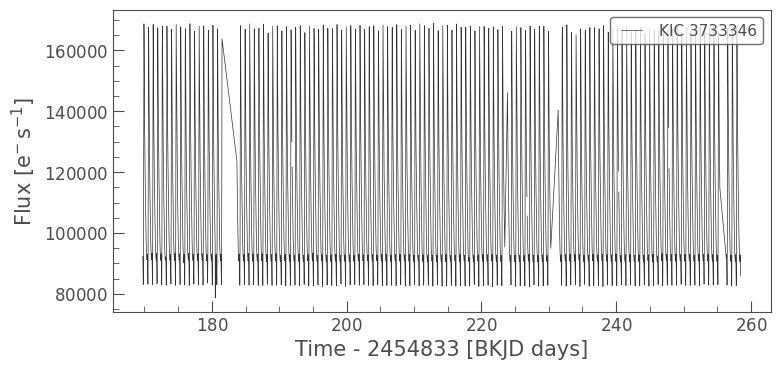

In [44]:
lc_search = lk.search_lightcurve('KIC 3733346', author='Kepler', quarter=2)
lc = lc_search.download()
lc.plot();

---
# 3. Supernovae Light Curves (Needs Documentation)

We can extract light curves of any transient phenomena, including supernovae. However this analysis presents a few unique challenges compared to looking at isolated point sources. Some basic limitations of our prior method include the fact that supernovae reside in a host galaxy which may itself change over time due to factors like active galactic nuclei (AGN). Common detrending methods, such as “Self Flat Fielding” (SFF) assume that movements of the supernova venter is entirely due to movement of the spacecraft, even though transience creates actual astrophysical motion as the photocenter gets weighted towards the increasingly bright transient’s photocenter.

\

As such, we aim to make a custom supernova lightcurve through the following:

1. Create an appropriate aperture mask to isolate the transient from its host galaxy

2. Extract aperture photometry of both the supernova and the background attributable to the host galaxy

3. Apply “Self Flat Fielding” (SFF) detrending techniques

4. Plot the lightcurve

\

We will focus on an unusual class of transient recently observed in K2, the so-called Fast-Evolving Luminous Transients or FELTs. These transients rise and fall within a mere few days, much shorter than conventional supernovae, which can last hundreds of days. The discovery of KSN2015k was recently reported by Rest et al. 2018 and summarized in at least two press releases from STSci and JPL.



In [48]:
import numpy as np
from lightkurve import search_targetpixelfile

In [49]:
tpf = search_targetpixelfile('EPIC 212593538', author="K2", campaign=6).download()
tpf.shape

(3545, 8, 8)

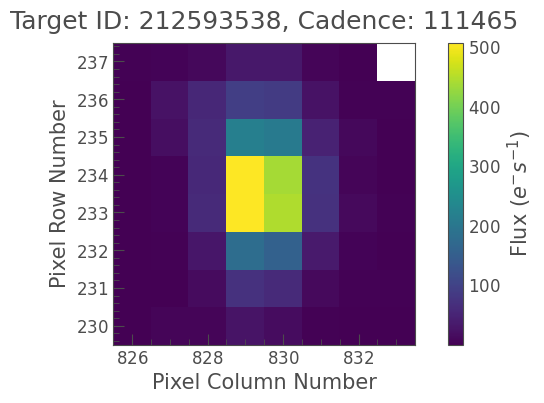

In [50]:
tpf.plot(frame=100);

In [51]:
postage_stamp_mask = tpf.hdu[2].data > 0
postage_stamp_mask.sum()

63

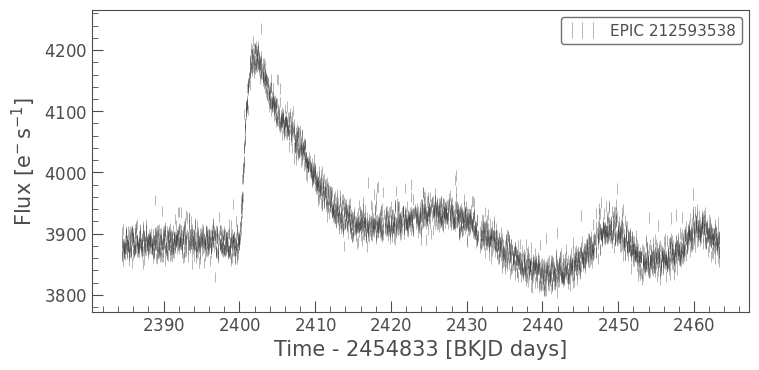

In [52]:
lc_raw = tpf.to_lightcurve(aperture_mask='all')
_, spurious_cadences = lc_raw.flatten().remove_outliers(return_mask=True)
lc_clean = lc_raw[~spurious_cadences]
lc_clean.errorbar(alpha=0.5, normalize=False);

We indeed see what looks like a sharply-rising phenomenon at 2400 - 2415 days, distinct from the smoothly-varying background, which could arise from either instrumental artifacts or host-galaxy.

\

Once we have our aperture and background masks, we can estimate the net flux:
$$
f_{net}(t)=f_{aper}(t)-f_b(t)\cdot N_{aper}
$$
where $f_{aper}$ is the total summed flux in an aperture of size $N_{aper}$ pixels, and $f_b$ is our estimate for the (spatially-flat) background level per pixel, in each cadence.

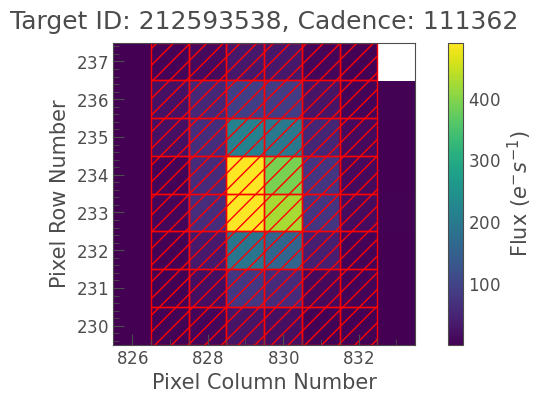

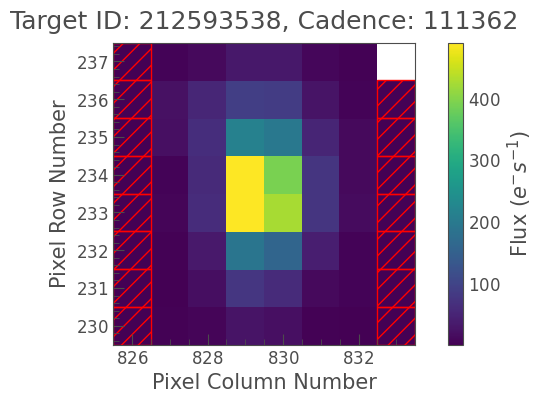

In [54]:
aperture_mask = postage_stamp_mask.copy()
aperture_mask[:,-1] = False
aperture_mask[:,0] = False
background_mask = ~aperture_mask & postage_stamp_mask
N_targ_pixels, N_back_pixels = aperture_mask.sum(), background_mask.sum()
tpf.plot(aperture_mask=aperture_mask);
tpf.plot(aperture_mask=background_mask);

Now apply the equations and drop the previously-identified spurious cadences.

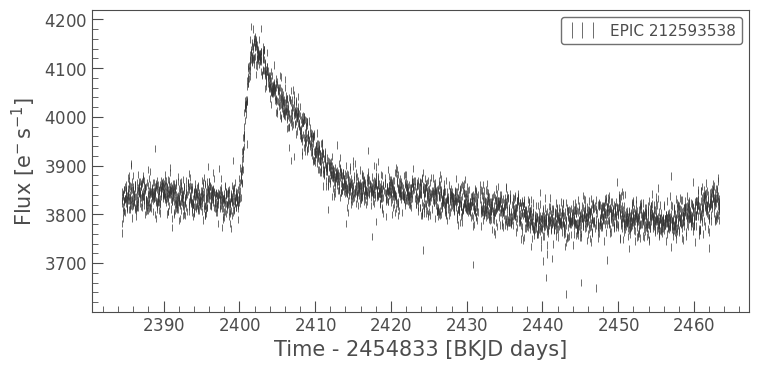

In [55]:
lc_aper = tpf.to_lightcurve(aperture_mask=aperture_mask)
lc_back_per_pixel = tpf.to_lightcurve(aperture_mask=background_mask) / N_back_pixels
lc_net = lc_aper - lc_back_per_pixel.flux * N_targ_pixels

lc_net = lc_net[~spurious_cadences]
lc_net.errorbar();

We no longer see the instrumentally-induced background wiggles.
$\boxed{ } $